# Imports

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm

from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications.resnet50 import preprocess_input


from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor, as_completed
from tensorflow.image import resize


# Access Dataset
- Within the Dataset, patient age and sex is provided with diagnosis for both the left and right eye being given. One hot encoding is used for the ocular conditions, each condition is represented by its own column where for each image a binary value of 1 or 0 is given to indicate the absence of presence of a disease. The labels coloumn includes the actual diagnosis label for the patient with the target column providing a binary vector representation of the conditions aligning with the individual conditions problem. 




In [14]:
df_data = pd.read_csv('dataset\\full_df.csv')
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


# Evaluating the first round of training of the ResNet 50 Model 
- To overcome the challenges faced in the first train of the model, such as overfitting and class imbalance, hence we will apply data augmentation, model regularisation and early stopping. 


# Data Distribution
- Below is shown the distribution of images available for each different ocular condition. The different diseases are encoded into individual coloums as N (Normal), D (Diabetes), G (Glaucoma), C (Cataract) , A (Age related Macular Degeneration), H (Hypertension), M (Pathological Myopia), O (Other diseases/abnormalities). They have binary indicators 0 or 1 to specify the absence or presence of a condition. This is also know as one-hot encoding. Thus, the dataset structure indicates multiple labels per image, allowing for multi-label classifcation.

- Conditions G, C, A, H and M are minority classes since they have low image samples, causing class imbalance. 

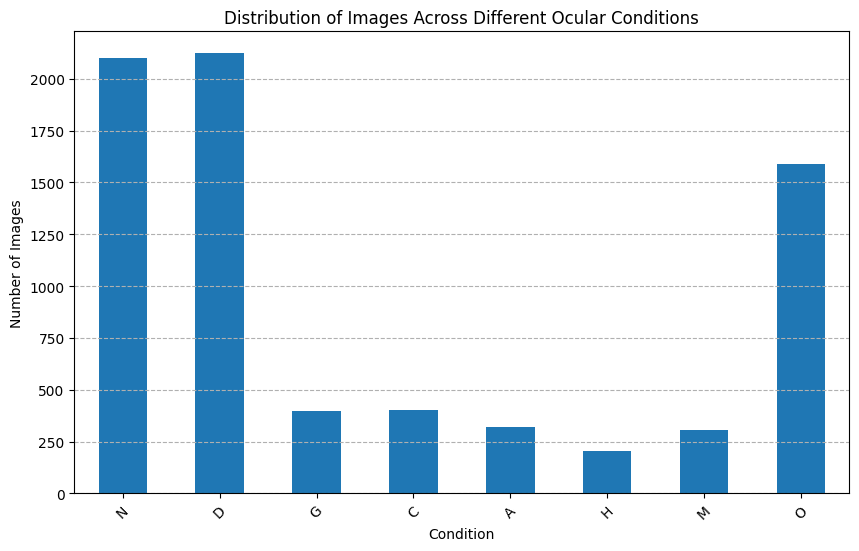

In [3]:
# Sum up the occurrences of each condition
class_counts = df_data[['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']].sum()

# Plotting
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Distribution of Images Across Different Ocular Conditions')
plt.xlabel('Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

plt.show()

In [4]:
class_distribution = df_data[['N','D','G', 'C', 'A', 'H', 'M', 'O']].sum()
print(class_distribution)

N    2101
D    2123
G     397
C     402
A     319
H     203
M     306
O    1588
dtype: int64


# Dealing with class imbalance - Data Augmentation 
- Data augmentation involves artificially increasing the size of your dataset by generating new data by resusing exisitng data, useful for underrepresented classes. Examples include rotations, flipping, noise, colour variations. 
- Will increase each minority class size to 2000 images by using the class counts and classes with less than 2000 images will be augmeneted to increase their size to 2000.
- The following minority classes should have their class sizes balanced -  G (Glaucoma), C (Cataract) , A (Age related Macular Degeneration), H (Hypertension), M (Pathological Myopia).

In [15]:
# Split the DataFrame into training and test sets
df_train, df_test = train_test_split(df_data, test_size=0.2, random_state=42)

Filtering the Minority Classes

N    1709
D    1677
G     313
C     320
A     260
H     158
M     239
O    1261
dtype: int64


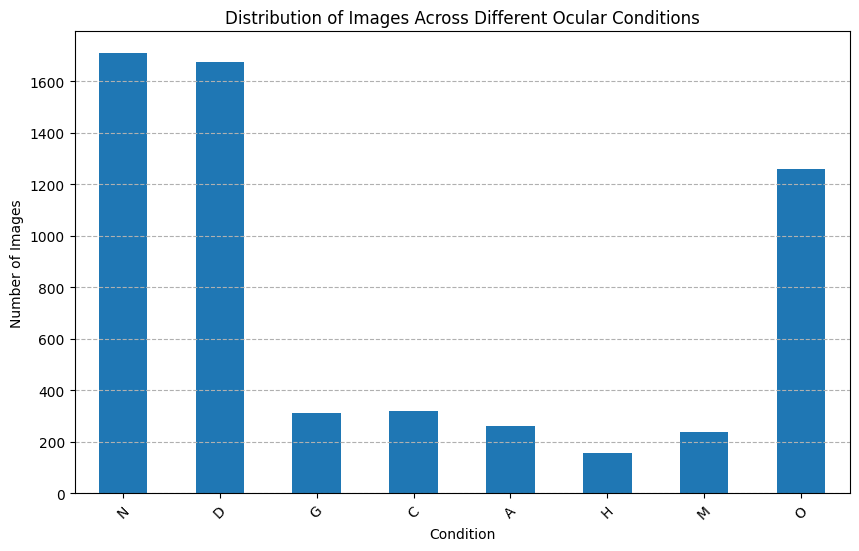

In [6]:
train_class_distribution = df_train[['N','D','G', 'C', 'A', 'H', 'M', 'O']].sum()
print(train_class_distribution)

# Plotting
plt.figure(figsize=(10, 6))
train_class_distribution.plot(kind='bar')
plt.title('Distribution of Images Across Different Ocular Conditions')
plt.xlabel('Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

plt.show()


In [5]:
# Current counts for each class from the user's data
current_counts = {
    'N': 1709,
    'D': 1677,
    'G': 313,
    'C': 320,
    'A': 260,
    'H': 158,
    'M': 239,
    'O': 1261
}

# The target count is the maximum current count
target_count = max(current_counts.values())

# Calculate the number of augmentations needed for each class
augmentations_needed = {class_label: max(0, (target_count // current_counts[class_label]) - 1) 
                        for class_label in current_counts}

augmentations_needed

{'N': 0, 'D': 0, 'G': 4, 'C': 4, 'A': 5, 'H': 9, 'M': 6, 'O': 0}

In [48]:
augmentation = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

save_directory = 'dataset/augmented_images/'
os.makedirs(save_directory, exist_ok=True)

# The augmentations_needed dictionary now uses numerical indices as keys
augmentations_needed = {
    0: 0, 1: 0, 2: 4, 3: 4, 4: 5, 5: 9, 6: 6, 7: 0
}



# Assuming df_train is your DataFrame and it has a 'target' column that is already in the correct format (list of integers)
def augment_and_save_image(row, save_directory, augmentation):
    img_path = os.path.join('dataset/ODIR-5K/Training Images', row['filename'])
    img = load_img(img_path)
    img = img.resize((256, 256))  # Resize image if necessary
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    augmented_image_paths = []

    # Determine the number of augmentations needed based on the target
    # Assume targets are in a list format, you might need to adjust this if stored differently
    targets = eval(row['target']) if isinstance(row['target'], str) else row['target']
    max_augmentations_needed = max([augmentations_needed[i] for i, label in enumerate(targets) if label == 1])

    for i in range(max_augmentations_needed):
        for batch in augmentation.flow(x, batch_size=1, save_prefix='aug_', save_format='jpeg'):
            # Create a unique filename using class index and augmentation index
            unique_filename = f'aug_{i}_{row["filename"]}'
            # Generate the full path for saving
            augmented_image_path = os.path.join(save_directory, unique_filename)
            # Save the image to the full path
            save_img(augmented_image_path, batch[0])
            # Append just the filename to the list
            augmented_image_paths.append(unique_filename)
            break  # Only save one image per augmentation to avoid infinite loop

    return augmented_image_paths, targets  # Return just the filenames and the original target list

# Example usage with ThreadPoolExecutor
updated_image_paths = []
updated_labels = []

with ThreadPoolExecutor(max_workers=4) as executor:
    tasks = []
    for index, row in df_train.iterrows():
        tasks.append(executor.submit(augment_and_save_image, row, save_directory, augmentation))

    for future in tqdm(as_completed(tasks), total=len(tasks), desc="Augmenting Images"):
        try:
            paths, targets = future.result()
            # Extend the list of paths and labels only if paths are returned
            if paths:
                updated_image_paths.extend(paths)
                updated_labels.extend([targets] * len(paths))  # Duplicate the label for each augmented image
        except Exception as e:
            print(f"Error processing image: {e}")
            updated_image_paths.append(None)  # Append None to indicate an error occurred
            updated_labels.append(None)

# Check if lengths match and create DataFrame
if len(updated_image_paths) == len(updated_labels):
    df_augmented_minority = pd.DataFrame({'filename': updated_image_paths, 'target': updated_labels})
else:
    print("Error: The lengths of updated_image_paths and updated_labels are not the same.")


Augmenting Images:   0%|          | 0/5113 [00:00<?, ?it/s]

In [47]:

# Create a new DataFrame to hold the augmented image paths and labels
augmented_df = pd.DataFrame({'filename': updated_image_paths, 'target': updated_labels})

augmented_df.head()




,filename,target
0,dataset/augmented_images/aug_0_2152_left.jpg,"[0, 0, 0, 1, 0, 0, 0, 0]"
1,dataset/augmented_images/aug_1_2152_left.jpg,"[0, 0, 0, 1, 0, 0, 0, 0]"
2,dataset/augmented_images/aug_2_2152_left.jpg,"[0, 0, 0, 1, 0, 0, 0, 0]"
3,dataset/augmented_images/aug_3_2152_left.jpg,"[0, 0, 0, 1, 0, 0, 0, 0]"
4,dataset/augmented_images/aug_0_540_right.jpg,"[0, 0, 0, 0, 1, 0, 0, 0]"


In [40]:
# Create a DataFrame to store the updated image paths and labels
if len(updated_image_paths) == len(updated_labels):
    df_augmented_minority = pd.DataFrame({'filename': updated_image_paths, 'target': updated_labels})
else:
    print("Error: The lengths of updated_image_paths and updated_labels are not the same.")


Error: The lengths of updated_image_paths and updated_labels are not the same.


In [43]:
# Concatenate the original and augmented minority class DataFrames
df_train_augmented = pd.concat([df_train, df_augmented_minority], axis=0)

df_train_augmented.head()


,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
2273,3159.0,62.0,Male,3159_left.jpg,3159_right.jpg,normal fundus,normal fundus,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",3159_right.jpg
5609,3315.0,57.0,Male,3315_left.jpg,3315_right.jpg,normal fundus,normal fundus,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",3315_left.jpg
4614,2152.0,58.0,Female,2152_left.jpg,2152_right.jpg,cataract,normal fundus,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",2152_left.jpg
3658,542.0,64.0,Male,542_left.jpg,542_right.jpg,diabetic retinopathy,maculopathy,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",542_left.jpg
471,540.0,82.0,Male,540_left.jpg,540_right.jpg,normal fundus,dry age-related macular degeneration，diabetic ...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,../input/ocular-disease-recognition-odir5k/ODI...,['A'],"[0, 0, 0, 0, 1, 0, 0, 0]",540_right.jpg


In [44]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = datagen.flow_from_dataframe(
    dataframe=df_train_augmented,  # Use the training part of the split
    directory='dataset/ODIR-5K/Training Images', 
    x_col='filename',
    y_col='target',
    subset='training',
    target_size=(224,224),  
    batch_size=32,
    class_mode='categorical'
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=df_train,  # Use the training part of the split
    directory='dataset/ODIR-5K/Training Images',
    x_col='filename',
    y_col='target',
    subset='validation',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

c:\Users\duwak\.conda\envs\TF\lib\site-packages\keras\preprocessing\image.py:989: UserWarning: Found 4936 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn('Found {} invalid image filename(s) in x_col="{}". '


Found 4091 validated image filenames belonging to 2 classes.
Found 1022 validated image filenames belonging to 2 classes.


In [ ]:
# For the test set, you can create a separate ImageDataGenerator instance without a validation split
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,  # Use the separate test DataFrame
    directory='dataset/ODIR-5K/Training Images',
    x_col='filename',
    y_col='target',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Typically, you don't want to shuffle the test set
)

In [14]:
# Split the DataFrame into training and test sets
df_train, df_test = train_test_split(df_data, test_size=0.2, random_state=42)

labels = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O'] 

# Define your minority classes
minority_classes = ['G', 'C', 'A', 'H', 'M', 'O']

# Filter out the minority classes from the training DataFrame
df_minority = df_train[df_train['labels'].isin(minority_classes)]

# Define your augmentation configuration
augmentation = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generate and save augmented images
augmented_image_paths = []  # This will store the paths of augmented images
for index, row in df_minority.iterrows():
    img_path = os.path.join('dataset/ODIR-5K/Training Images', row['filename'])
    img = load_img(img_path)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    
    i = 0
    for batch in augmentation.flow(x, batch_size=1, save_to_dir='dataset/augmented_minority_images', save_format='jpeg'):
        augmented_image_path = os.path.join('dataset/augmented_minority_images', f'aug_{i}_{row["filename"]}')
        augmented_image_paths.append((augmented_image_path, row['labels']))
        i += 1
        if i >= 5:  # Limit the number of generated images per original image
            break

# Now, you can create a DataFrame from the augmented images
df_augmented_minority = pd.DataFrame(augmented_image_paths, columns=['filename', 'labels'])

# Combine the augmented images with the original training DataFrame
df_train_augmented = pd.concat([df_train, df_augmented_minority], ignore_index=True)

In [15]:
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

# Training generator
train_generator = datagen.flow_from_dataframe(
    dataframe=df_train_augmented,  # Use the training part of the split
    directory='dataset/ODIR-5K/Training Images', 
    x_col='filename',
    y_col='target',
    subset='training',
    target_size=(224,224),  
    batch_size=32,
    class_mode='categorical'
)

# Validation generator
validation_generator = datagen.flow_from_dataframe(
    dataframe=df_train_augmented,  # Use the training part of the split
    directory='dataset/ODIR-5K/Training Images',
    x_col='filename',
    y_col='target',
    subset='validation',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

# For the test set, you can create a separate ImageDataGenerator instance without a validation split
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,  # Use the separate test DataFrame
    directory='dataset/ODIR-5K/Training Images',
    x_col='filename',
    y_col='target',
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Typically, you don't want to shuffle the test set
)

Found 4091 validated image filenames belonging to 8 classes.
Found 1022 validated image filenames belonging to 8 classes.
Found 1279 validated image filenames belonging to 8 classes.


In [ ]:
#df_train_augmented = pd.concat([df_majority,df_augmented_minority])


In [ ]:
class_names = ['G', 'C', 'A', 'H', 'M', 'O']
images_path = 'dataset/ODIR-5K/Training Images/'

# Get initial class counts from the dataframe and filter classes with less than 2000 images
class_image_counts = df_data[class_names].sum()
classes_to_augment = class_image_counts[class_image_counts < 2000].index.tolist()

# Define the image augmentation generator
augmentation = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    rescale=1./255 
)

def load_process_minority_image(file_path, label):
    if os.path.exists(file_path):
        img = tf.keras.preprocessing.image.load_img(file_path, target_size=(224, 224))
        img = tf.keras.preprocessing.image.img_to_array(img)
        return img, label
    return None, None


# Define the path where augmented images will be saved
augmented_images_path = 'dataset/minority_images/'

# Create directories for each class if they don't already exist
for cls in class_names:
    class_dir = os.path.join(augmented_images_path, cls)
    if not os.path.exists(class_dir):
        os.makedirs(class_dir)

# Update the handle_minority_image_result function to save images
def handle_minority_image_result(result, image_counter):
    img, label = result
    if img is not None and label is not None:
        for i, cls in enumerate(classes_to_augment):
            index = class_names.index(cls)  # Get the index of the class in the label list
            if label[index] == 1 and class_image_counts[cls] < 2000:
                augmentations_needed = min(2000 - class_image_counts[cls], 5)
                for _ in range(augmentations_needed):
                    augmented_img = augmentation.random_transform(img)
                    # Save the augmented image to the corresponding class directory
                    save_path = os.path.join(augmented_images_path, cls, f"augmented_{image_counter[cls]}.png")
                    tf.keras.preprocessing.image.save_img(save_path, augmented_img)
                    image_counter[cls] += 1
                    class_image_counts[cls] += 1
                    if class_image_counts[cls] >= 2000:
                        break

# Initialize an image counter for naming images
image_counter = {cls: 0 for cls in classes_to_augment}

# No need to collect images in lists anymore, so the rest of the code is adapted to this change
with ThreadPoolExecutor(max_workers=8) as executor:
    futures = []
    for _, row in tqdm(df_data.iterrows(), total=df_data.shape[0], desc='Processing images'):
        label = eval(row['target'])  # Assuming 'target' is a string representation of the list
        for cls in classes_to_augment:
            index = class_names.index(cls)
            if label[index] == 1:
                for eye in ['Left-Fundus', 'Right-Fundus']:
                    if row[eye]:  # Assuming non-empty strings evaluate to True
                        image_path = os.path.join(images_path, row[eye])
                        futures.append(executor.submit(load_process_minority_image, image_path, label))

    # Apply augmentation and save images
    for future in tqdm(futures, desc='Applying augmentation and saving images'):
        handle_minority_image_result(future.result(), image_counter)

# Since images are saved to disk, there's no need to convert them to NumPy arrays here.
# You can later load them directly from the disk when training your model.

print("Image counts per class after augmentation:")
for cls in classes_to_augment:
    print(f"{cls}: {class_image_counts[cls]}")


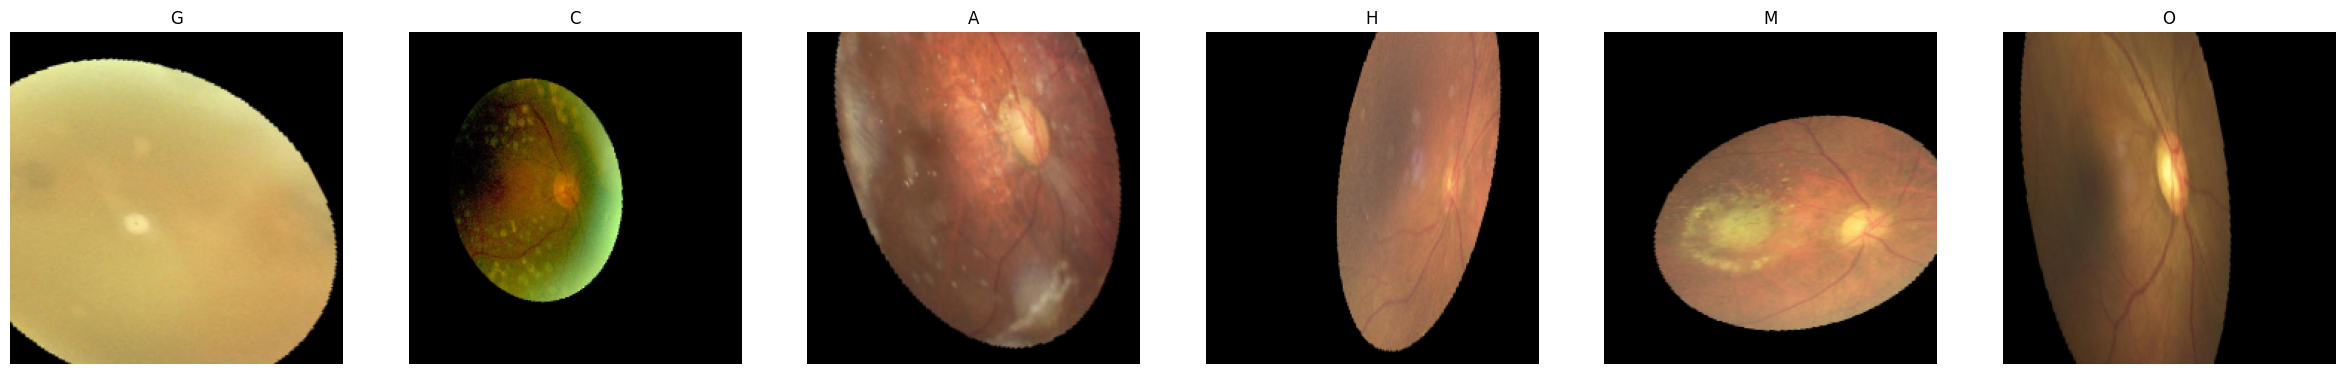

In [15]:
#plot the images
fig, axs = plt.subplots(1, 6, figsize=(30,10))

for i, cls in enumerate(class_names):
    img_path = os.path.join(augmented_images_path, cls, f"augmented_0.png")
    img = plt.imread(img_path)
    axs[i].imshow(img)
    axs[i].set_title(cls)
    axs[i].axis('off')
    
plt.show()

# Loading and Visualising the majority classes 

In [3]:
# Directory where processed images will be saved
processed_images_dir = 'dataset/majority_images/'
if not os.path.exists(processed_images_dir):
    os.makedirs(processed_images_dir)

images_path = 'dataset/ODIR-5K/Training Images/'
majority_classes = ['N', 'D']
# Optimized DataFrame filtering
mask = df_data[majority_classes].sum(axis=1) > 0
df_data_majority = df_data[mask]

In [ ]:


# Directory where processed images will be saved
processed_images_dir = 'dataset/majority_images/'
if not os.path.exists(processed_images_dir):
    os.makedirs(processed_images_dir)

# Define the path to the original images
images_path = 'dataset/ODIR-5K/Training Images/'

# Majority classes
majority_classes = ['N', 'D']

# Set to track processed images to avoid duplication
processed_images_set = set()

def save_processed_image(row, images_path, processed_images_dir, majority_classes, processed_images_set):
    for eye in ['Left-Fundus', 'Right-Fundus']:
        if row[eye]:  # Check if the image path is not empty
            file_path = os.path.join(images_path, row[eye])
            img_name = os.path.basename(file_path)
            
            # Check if image has already been processed to avoid duplication
            if img_name in processed_images_set:
                continue  # Skip this image if it has already been processed
            
            if os.path.exists(file_path):
                img = tf.keras.preprocessing.image.load_img(file_path, target_size=(224, 224))
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                # Determine class from row and select folder
                for cls in majority_classes:
                    if row[cls] == 1:
                        class_dir = os.path.join(processed_images_dir, cls)
                        if not os.path.exists(class_dir):
                            os.makedirs(class_dir)
                        # Save image
                        save_file_path = os.path.join(class_dir, img_name)
                        if not os.path.exists(save_file_path):  # Check if the file already exists
                            tf.keras.preprocessing.image.save_img(save_file_path, img_array)
                            processed_images_set.add(img_name)  # Mark this image as processed
                        break  # Once saved in one class, no need to check other classes


# Use ThreadPoolExecutor to process images in parallel
with ThreadPoolExecutor(max_workers=8) as executor:
    futures = [executor.submit(save_processed_image, row, images_path, processed_images_dir, majority_classes, processed_images_set) 
               for _, row in df_data_majority.iterrows()]

# Wait for all futures to complete if necessary
# It's optional to track the progress. Uncomment the next line if you want to see the progress.
[future.result() for future in tqdm(futures, desc='Processing & Saving Images')]

print("All relevant images processed and saved.")





In [30]:
#count the number of images in each class
class_counts = df_data_majority[majority_classes].sum()
print(class_counts)

N    2101
D    2123
dtype: int64


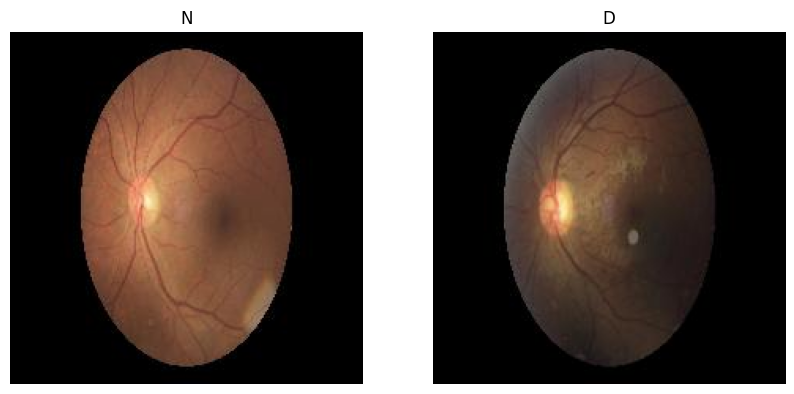

In [29]:
# Plot the images
fig, axs = plt.subplots(1, 2, figsize=(10,10))

for i, cls in enumerate(majority_classes):
    img_path = os.path.join(processed_images_dir, cls, f"{os.listdir(processed_images_dir + cls)[0]}")
    img = plt.imread(img_path)
    axs[i].imshow(img)
    axs[i].set_title(cls)
    axs[i].axis('off')
    
plt.show()


# Joining the minority and majority images

Found 13155 files belonging to 8 classes.
Using 10524 files for training.
Found 13155 files belonging to 8 classes.
Using 2631 files for validation.
['A', 'C', 'D', 'G', 'H', 'M', 'N', 'O']


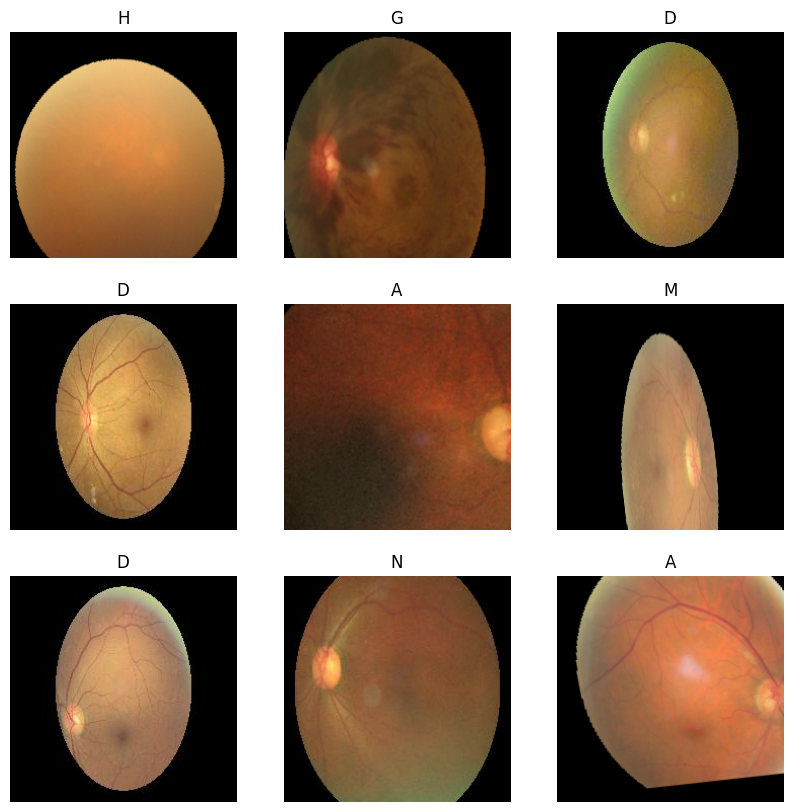

In [3]:
# create tf dataset from directory
image_size = (224, 224)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/balanced_images/",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset/balanced_images/",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

# Display the class names
class_names = train_ds.class_names
print(class_names)

# Visualize the data
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        
plt.show()
        

In [16]:
def one_hot_encode(image, label):
    label = tf.one_hot(label, depth=8)  # Assuming you have 8 classes
    return image, label

# Apply the one_hot_encode function to your training and validation datasets
train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(one_hot_encode)



In [17]:
print("size of training dataset: ", len(train_ds))
print("size of validation dataset: ", len(val_ds))

size of training dataset:  329
size of validation dataset:  83


Preparing augmentated data for training
- Splitting the augmented minority data into training and validation sets. 

In [18]:
# Prefetch the datasets
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.experimental.AUTOTUNE)


# Training the model

- A BatchNormalization layer and a Dropout layer are added immediately after flattening the output of the pretrained ResNet50 base. A Dense layer with both L1 and L2 regularization follows the Dropout layer. The regularization helps prevent overfitting by adding a penalty for larger weights, and Dropout randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Batch Normalization normalizes the inputs heading into the next layer, which ensures that the network always creates activations with the same distribution that we desire.

In [19]:
resnet_50_model = Sequential()

pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg', classes=8,
    weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable = False

resnet_50_model.add(pretrained_model)
resnet_50_model.add(Flatten())

# Add a batch normalization layer
resnet_50_model.add(BatchNormalization())

# Add a dropout layer with a 50% dropout rate
resnet_50_model.add(Dropout(0.5))

# Add a dense layer with L1 and L2 regularization
resnet_50_model.add(Dense(512, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)))

# Optional: add another batch normalization layer here if needed
# resnet_50_model.add(BatchNormalization())


# Final dense layer with softmax activation for classification
resnet_50_model.add(Dense(8, activation='softmax'))



In [20]:
resnet_50_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 8)                 4104      
                                                      

In [21]:
# Update the number of classes in the output layer to match the number of classes in your dataset
num_classes = 8

# Update the last dense layer in your model to have the correct number of units
resnet_50_model.layers[-1].units = num_classes

In [22]:
resnet_50_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = resnet_50_model.fit(train_ds, validation_data=val_ds, epochs=10, )

# Early Stopping 
- This is implemented to prevent overfitting if the validation loss begins to rise consisenly as training goes on. 

Evaluating Model 

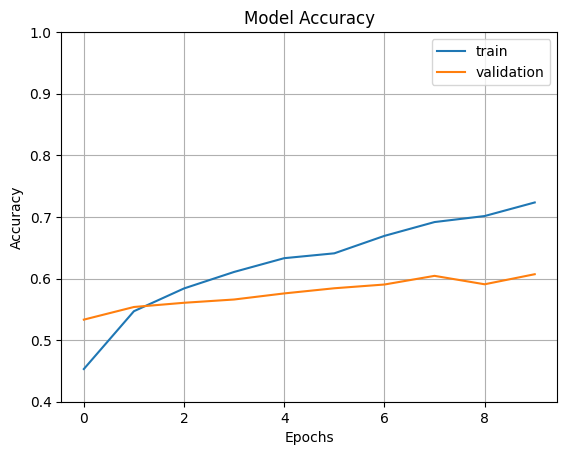

In [25]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

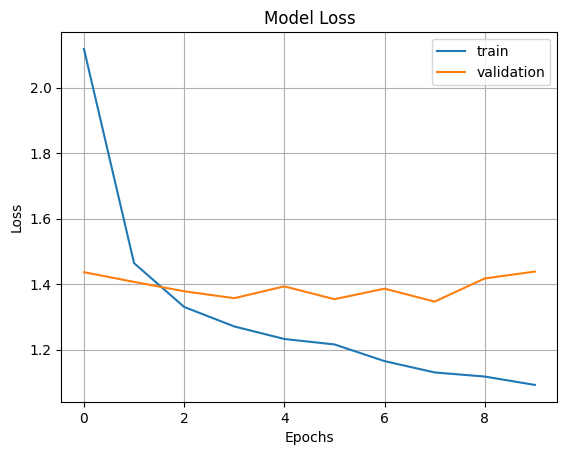

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Loading Test Data 

In [43]:
from pathlib import Path

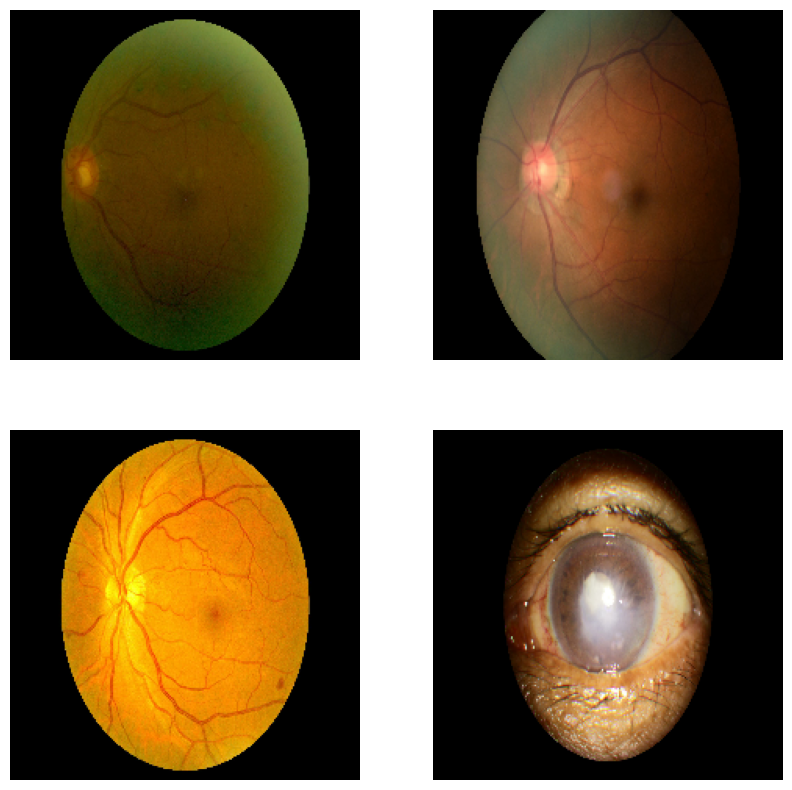

In [28]:
from pathlib import Path
def parse_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)

    return image

data_dir = Path('dataset/ODIR-5K/')
test_dataset = list(data_dir.glob('Testing Images/*'))


test_dataset = [str(path) for path in test_dataset]
test_dataset = tf.data.Dataset.from_tensor_slices(test_dataset)
test_dataset = test_dataset.map(parse_image)


# Now you can batch, shuffle, and prefetch the dataset as needed
test_dataset = test_dataset.batch(32)  # batching
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)  # prefetching


# Visualize the data
plt.figure(figsize=(10,10))

for i, image in enumerate(test_dataset.take(4)):
    ax = plt.subplot(2,2,i+1)
    plt.imshow(image[0] / 255)
    plt.axis('off')



In [29]:
print("size of test dataset: ", len(test_dataset))    

size of test dataset:  32


Making Predictions


In [37]:

resnet_50_model.evaluate(val_ds)

predictions = resnet_50_model.predict(val_ds)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

# Get the true classes
true_classes = np.concatenate([y for x, y in val_ds], axis=0)

# Get the class labels
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Use the sklearn function to get the classification report
from sklearn.metrics import classification_report
# Ensure true_classes is a 1D array of integer labels.
if len(true_classes.shape) > 1:  # This checks if true_classes is more than 1D
    true_classes = np.argmax(true_classes, axis=1)

# Ensure predicted_classes is also a 1D array of integer labels.
if len(predicted_classes.shape) > 1:
    predicted_classes = np.argmax(predicted_classes, axis=1)

# Now you can generate the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

83/83 [==============================] - 9s 112ms/step
              precision    recall  f1-score   support

      Normal       0.12      0.12      0.12       349
    Diabetes       0.12      0.11      0.11       342
    Glaucoma       0.18      0.21      0.19       426
    Cataract       0.11      0.06      0.08       333
         AMD       0.12      0.13      0.13       352
Hypertension       0.10      0.16      0.13       328
      Myopia       0.13      0.11      0.12       414
       Other       0.00      0.00      0.00        87

    accuracy                           0.13      2631
   macro avg       0.11      0.11      0.11      2631
weighted avg       0.12      0.13      0.12      2631



32/32 [==============================] - 4s 125ms/step


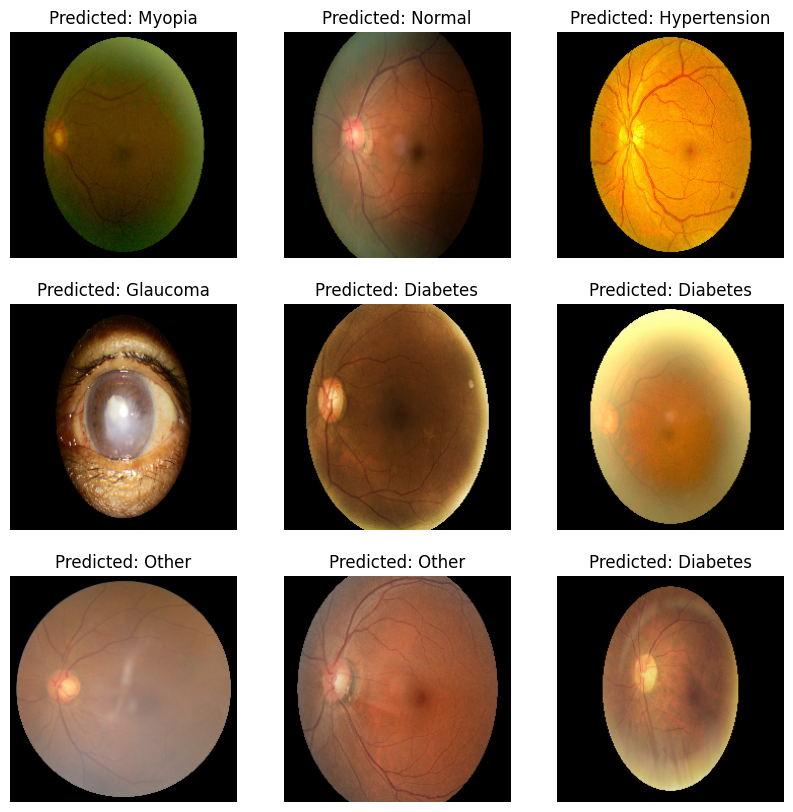

In [33]:
# Evaluate the model on the test dataset
resnet_50_model.evaluate(test_dataset)

predictions = resnet_50_model.predict(test_dataset)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
# Plot the first 9 images, their predicted labels, and the true labels
output_class=class_labels[np.argmax(predicted_classes[i])]
plt.figure(figsize=(10, 10))

for i, image in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[0] / 255)
    plt.title(f"Predicted: {class_labels[np.argmax(predictions[i])]}")
    plt.axis("off")

In [ ]:

# Get the class with the highest probability
pred_class = np.argmax(pred)
print(pred_class)

# Get the class labels
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
class_labels[pred_class]

# Get the top 3 class labels
top3_class_indices = pred[0].argsort()[-3:][::-1]
top3_class_indices

# Get the top 3 class labels
top3_class_labels = [class_labels[i] for i in top3_class_indices]
top3_class_labels

# Get the top 3 class probabilities
top3_class_probabilities = pred[0][top3_class_indices]
top3_class_probabilities

# Visualize the top 3 class labels and their probabilities
plt.bar(top3_class_labels, top3_class_probabilities)
plt.ylabel('Probability')
plt.xlabel('Class')
plt.title('Top 3 Predictions')
plt.show()

In [ ]:
# Save the model
resnet_50_model.save('resnet_50_model')